# Day 1: RNN Fundamentals

## Learning Objectives
- Understand why sequential data needs special architectures
- Implement a vanilla RNN from scratch
- Apply RNN to financial time series

---

In [1]:
# ============================================================
# DAY 1: RNN FUNDAMENTALS
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Libraries loaded! Device: {device}")
print(f"📚 Day 1: RNN Fundamentals")

✅ Libraries loaded! Device: cpu
📚 Day 1: RNN Fundamentals


## Part 1: The Problem with MLPs for Sequences

MLPs treat each input independently - they can't learn:
- Order matters (sequence position)
- Variable-length inputs
- Long-term dependencies

TEMPORAL DEPENDENCIES IN FINANCE

Autocorrelation of returns:
  Lag  1: 0.2907
  Lag  2: 0.0764
  Lag  5: 0.0234
  Lag 10: -0.0074


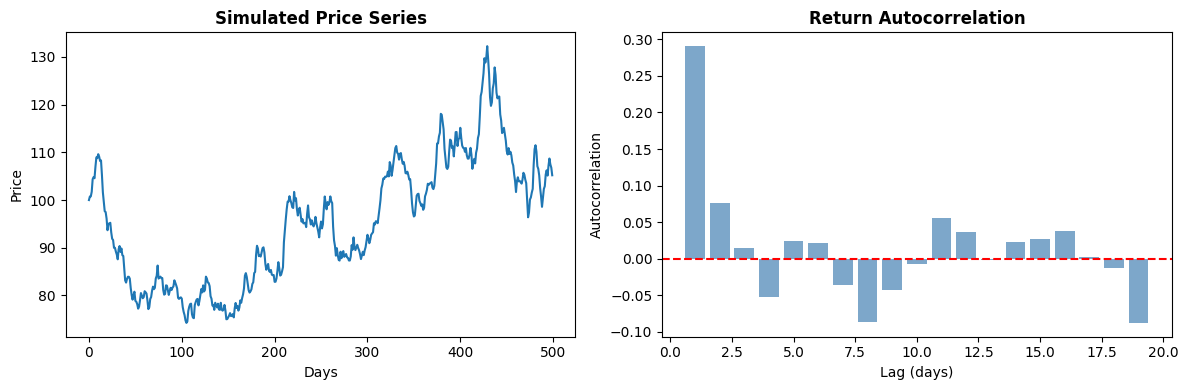


💡 Positive autocorrelation → past returns predict future returns!


In [2]:
# ============================================================
# TEMPORAL DEPENDENCIES IN FINANCIAL DATA
# ============================================================

print("TEMPORAL DEPENDENCIES IN FINANCE")
print("="*60)

# Generate synthetic price data with momentum
n_days = 500
np.random.seed(42)

# Simulate returns with autocorrelation
returns = [0]
for i in range(1, n_days):
    # Returns depend on previous return (momentum)
    momentum = 0.3 * returns[-1]
    noise = np.random.normal(0, 0.015)
    returns.append(momentum + noise)

returns = np.array(returns)
prices = 100 * np.cumprod(1 + returns)

# Calculate autocorrelation
def autocorrelation(x, lag):
    n = len(x)
    mean = np.mean(x)
    var = np.var(x)
    return np.sum((x[:-lag] - mean) * (x[lag:] - mean)) / ((n - lag) * var)

print("\nAutocorrelation of returns:")
for lag in [1, 2, 5, 10]:
    ac = autocorrelation(returns, lag)
    print(f"  Lag {lag:2d}: {ac:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(prices)
axes[0].set_title('Simulated Price Series', fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Price')

lags = range(1, 20)
autocorrs = [autocorrelation(returns, l) for l in lags]
axes[1].bar(lags, autocorrs, color='steelblue', alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Return Autocorrelation', fontweight='bold')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

print("\n💡 Positive autocorrelation → past returns predict future returns!")

## Part 2: Vanilla RNN Architecture

$$h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)$$
$$y_t = W_{hy} \cdot h_t + b_y$$

In [3]:
# ============================================================
# VANILLA RNN FROM SCRATCH
# ============================================================

print("VANILLA RNN IMPLEMENTATION")
print("="*60)

class VanillaRNN(nn.Module):
    """Simple RNN for educational purposes."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Weights
        self.W_xh = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True)
        self.W_hy = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Initialize hidden state
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        # Process sequence
        for t in range(seq_len):
            x_t = x[:, t, :]
            h = torch.tanh(self.W_xh(x_t) + self.W_hh(h))
        
        # Output from final hidden state
        return self.W_hy(h)

# Test
rnn = VanillaRNN(input_size=3, hidden_size=32, output_size=1)
x = torch.randn(4, 20, 3)  # batch=4, seq_len=20, features=3
output = rnn(x)

print(f"\nInput shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nParameters: {sum(p.numel() for p in rnn.parameters()):,}")

VANILLA RNN IMPLEMENTATION

Input shape:  torch.Size([4, 20, 3])
Output shape: torch.Size([4, 1])

Parameters: 1,185


## Part 3: Training RNN on Financial Data

In [4]:
# ============================================================
# PREPARE DATA AND TRAIN
# ============================================================

print("TRAINING RNN FOR RETURN PREDICTION")
print("="*60)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Features: returns, 5-day volatility, 5-day momentum
features = np.column_stack([
    returns,
    pd.Series(returns).rolling(5).std().fillna(0).values,
    pd.Series(returns).rolling(5).mean().fillna(0).values,
])

# Normalize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences
seq_length = 20
X, y = create_sequences(features_scaled, seq_length)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = torch.FloatTensor(X[:split]), torch.FloatTensor(X[split:])
y_train, y_test = torch.FloatTensor(y[:split, 0:1]), torch.FloatTensor(y[split:, 0:1])

print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")

# Create model and train
model = VanillaRNN(input_size=3, hidden_size=32, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(
    TensorDataset(X_train, y_train), 
    batch_size=32, shuffle=True
)

history = {'train': [], 'test': []}

print("\nTraining...")
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_b), y_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test).item()
    
    history['train'].append(epoch_loss / len(train_loader))
    history['test'].append(test_loss)
    
    if (epoch + 1) % 25 == 0:
        print(f"  Epoch {epoch+1}: Train={history['train'][-1]:.4f}, Test={test_loss:.4f}")

print("\n✅ Training complete!")

TRAINING RNN FOR RETURN PREDICTION
Training: torch.Size([384, 20, 3])
Test: torch.Size([96, 20, 3])

Training...
  Epoch 25: Train=0.8024, Test=1.1618
  Epoch 50: Train=0.6719, Test=1.1708
  Epoch 75: Train=0.4897, Test=1.2906
  Epoch 100: Train=0.3360, Test=1.5531

✅ Training complete!


EVALUATION

Correlation: 0.1914
Direction Accuracy: 53.1%


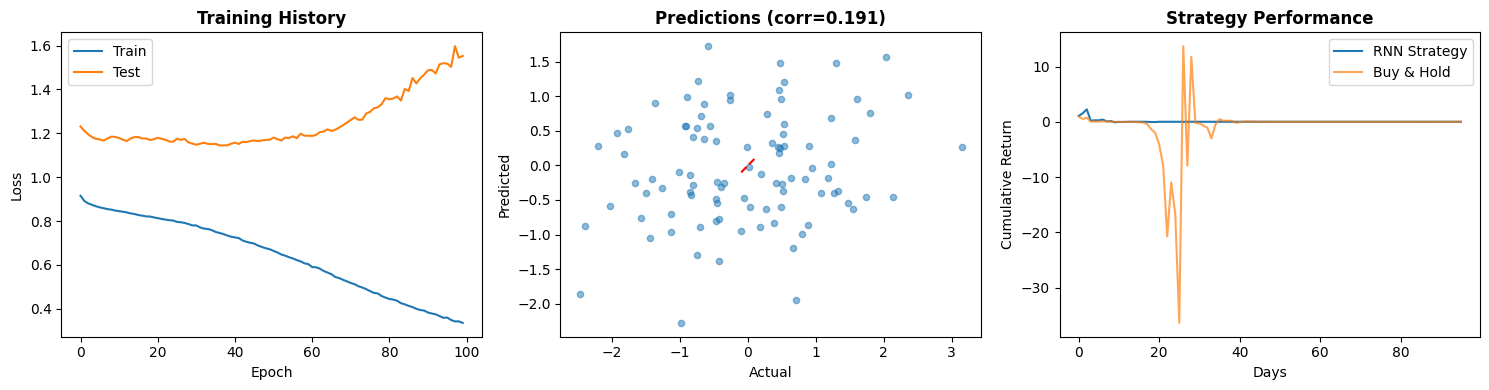

In [5]:
# ============================================================
# EVALUATE
# ============================================================

print("EVALUATION")
print("="*60)

model.eval()
with torch.no_grad():
    preds = model(X_test).numpy().flatten()
    actuals = y_test.numpy().flatten()

# Metrics
correlation = np.corrcoef(preds, actuals)[0, 1]
direction_acc = np.mean(np.sign(preds) == np.sign(actuals))

print(f"\nCorrelation: {correlation:.4f}")
print(f"Direction Accuracy: {direction_acc*100:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history['train'], label='Train')
axes[0].plot(history['test'], label='Test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training History', fontweight='bold')
axes[0].legend()

# Scatter
axes[1].scatter(actuals, preds, alpha=0.5, s=20)
axes[1].plot([-0.1, 0.1], [-0.1, 0.1], 'r--')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Predictions (corr={correlation:.3f})', fontweight='bold')

# Strategy returns
strategy = actuals * np.sign(preds)
cum_strategy = np.cumprod(1 + strategy)
cum_market = np.cumprod(1 + actuals)

axes[2].plot(cum_strategy, label='RNN Strategy')
axes[2].plot(cum_market, label='Buy & Hold', alpha=0.7)
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Cumulative Return')
axes[2].set_title('Strategy Performance', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

In [6]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║              DAY 1 COMPLETE: RNN FUNDAMENTALS                    ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Temporal dependencies in financial data                      ║
║  ✓ Vanilla RNN architecture                                     ║
║  ✓ Weight sharing across timesteps                              ║
║  ✓ Training RNN for return prediction                           ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 2 - Vanishing Gradient Problem
""")


╔══════════════════════════════════════════════════════════════════╗
║              DAY 1 COMPLETE: RNN FUNDAMENTALS                    ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Temporal dependencies in financial data                      ║
║  ✓ Vanilla RNN architecture                                     ║
║  ✓ Weight sharing across timesteps                              ║
║  ✓ Training RNN for return prediction                           ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 2 - Vanishing Gradient Problem

